# Bayesian Linear Regression

Limit hypothesis to linear functions (linear in parameters): $ y(x,w) = w^T \phi(x) $

In 1-D for $\phi(x)=x$: $ y(x,w) = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}^T \begin{bmatrix} 1 \\ x \end{bmatrix} $

Task is to infer $w$ given data $\mathcal{D}=\{y_i,x_i\}_{i=1}^N$

Assume data is corrupted by additive, independent Gaussian noise (zero mean with precision $\beta$): $y = w^Tx + \epsilon$ where $\epsilon \sim \mathcal{N}(0,\beta^{-1})$

Likelihood (evidence a specific data point provides for a specific model) assuming data is independent and $\beta$ is known: $p(y|X,w) = \prod_{i=1}^N \mathcal{N}(y_i|w^Tx_i,\beta^{-1})$ where $X=[x_1,...,x_N]^T$ and $y=[y_1,...,y_N]^T$

Specify a conjugate prior over $w$ to the Gaussian likelihood which is also a Gaussian (zero mean with precision $\alpha$ assuming independence): $p(w) = \mathcal{N}(w|m_0,S_0) = \mathcal{N}(w|0,\alpha^{-1}I)$

Bayes rule to find the posterior: $p(w|y,X) = \frac{p(y|X,w)p(w)}{\int p(y|X,w)p(w) dw} \propto p(y|X,w)p(w)$

Due to conjugacy the posterior is also Gaussian and can be written in closed form: $p(w|y) = \mathcal{N}(w|m_N,S_N)$ where $m_N=S_N(S_0^{-1}m_0+\beta X^T y),\ S_N=(S_o^{-1} + \beta X^T X)^{-1}$

Predictive posterior is found by marginalising out the parameters $w$ which is also a Gaussian: $p(y_*|y,x_*,X,\alpha,\beta) = \int p(y_*|x_*,w,\beta) p(w|y,X,\alpha,\beta) = \mathcal{N}(y_*|m_N^Tx_*,\beta^{-1}+x_*^TS_Nx_*)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

### Generate dataset

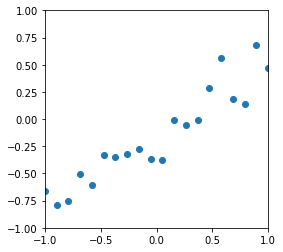

In [2]:
n = 20
X = np.concatenate((np.ones((n, 1)), np.linspace(-1, 1, n).reshape(-1, 1)), axis=1)
w = np.array([-0.1, 0.8])
beta = 7
y = np.random.normal(X @ w, 1/beta, X.shape[0])
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
ax.scatter(X[:, 1], y)

In [3]:
def plot_over_w(m_plot, S_plot, ax):
    dist = multivariate_normal(m_plot.flatten(), S_plot)
    x = np.linspace(-1, 1, 100)
    w0s, w1s = np.meshgrid(x, x)
    pos = np.vstack((w0s.flatten(), w1s.flatten())).T
    ax.contourf(w0s, w1s, dist.pdf(pos).reshape(100, 100))
    ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
    ax.set_xlabel("w0"), ax.set_ylabel("w1")

def plot_lines(mu, sigma, ax, X_plot=None, y_plot=None, n=10):
    w_sam = np.random.multivariate_normal(mu.flatten(), sigma, n)
    ax.plot(X[:, 1], X @ w_sam.T, color='r')
    if X_plot is not None:
        ax.scatter(X_plot[:, 1], y_plot)
    ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
    ax.set_xlabel("x"), ax.set_ylabel("y")

### Prior is defined and samples drawn

/var/folders/xq/vn60xb7s2cd4ggcbjcn35s4dpzfmr3/T/ipykernel_56835/846617887.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


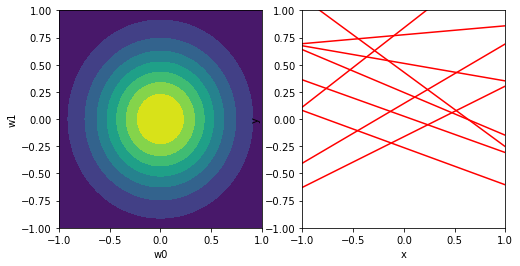

In [4]:
m_0 = np.array([[0, 0]]).T
alpha = 5
S_0 = 1/alpha * np.identity(2)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
plot_over_w(m_0, S_0, ax0)
plot_lines(m_0, S_0, ax1)
fig.show()

In [17]:
w_range = np.linspace(-1, 1, 50)
point_likelihood = np.ones((len(w_range), len(w_range)))
total_likelihood = point_likelihood.copy()

def likelihood_plot(X_plot, y_plot, ax):
    for i in range(len(w_range)):
        for j in range(len(w_range)):
            w = np.array([w_range[i], w_range[j]])
            point_likelihood[j, i] = multivariate_normal(X_plot @ w, 1/beta).pdf(y_plot)
    ax.contourf(w_range, w_range, point_likelihood)
    ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
    ax.set_xlabel("w0"), ax.set_ylabel("w1")

def total_likelihood_plot(X_plot, y_plot, ax):
    for k in range(len(X_plot)):
        for i in range(len(w_range)):
            for j in range(len(w_range)):
                w = np.array([w_range[i], w_range[j]])
                total_likelihood[j, i] *= multivariate_normal(X_plot[k] @ w, 1/beta).pdf(y_plot[k])
    ax.contourf(w_range, w_range, total_likelihood)
    ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
    ax.set_xlabel("w0"), ax.set_ylabel("w1")

def posterior(X_plot, y_plot, m, S):
    S_n = np.linalg.inv(np.linalg.inv(S) + beta * X_plot.T @ X_plot)
    m_n = S_n @ (np.linalg.inv(S) @ m + beta * X_plot.T @ y_plot)
    return m_n, S_n

def predictive_posterior(m_N, S_N, x_star):
    m_star = m_N.T @ x_star
    S_star = 1/beta + x_star.T @ S_N @ x_star
    return np.column_stack((m_star, S_star)).flatten()

def plot_predictive_dist(m, S, ax, x_sam=None, y_sam=None, lim=1):
    x_stars = np.concatenate((np.ones((20, 1)), np.linspace(-2, 2, 20).reshape(-1, 1)), axis=1)
    means_stds = np.zeros((len(x_stars), 2))
    for i, x_star in enumerate(x_stars):
        means_stds[i] = predictive_posterior(m, S, x_star.reshape(-1, 1))
    ax.plot(x_stars[:, 1], means_stds[:, 0])
    ax.fill_between(x_stars[:, 1], means_stds[:, 0] - 2*means_stds[:, 1],
                    means_stds[:, 0] + 2*means_stds[:, 1], alpha=0.3)
    if x_sam is not None:
        ax.scatter(x_sam[:, 1], y_sam, c='tab:blue')
    ax.set_xlim(-lim, lim), ax.set_ylim(-lim, lim)
    ax.set_xlabel("x"), ax.set_ylabel("y")

### Draw samples from dataset and evaluate likelihood, posterior and predictive distribution.
- Column 1: likelihood for all samples seen so far
- Column 2: posterior over the weights
- Column 3: samples drawn from the posterior
- Column 4: predictive distribution showing mean and 2 standard deviations

Note: the variance of the Gaussian noise is assumed to be known

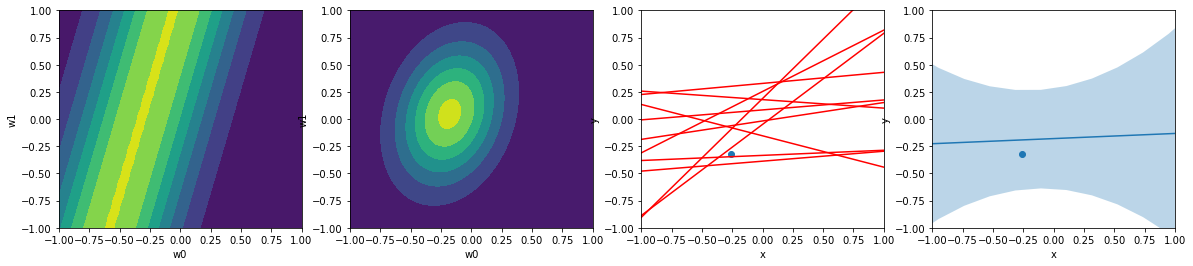

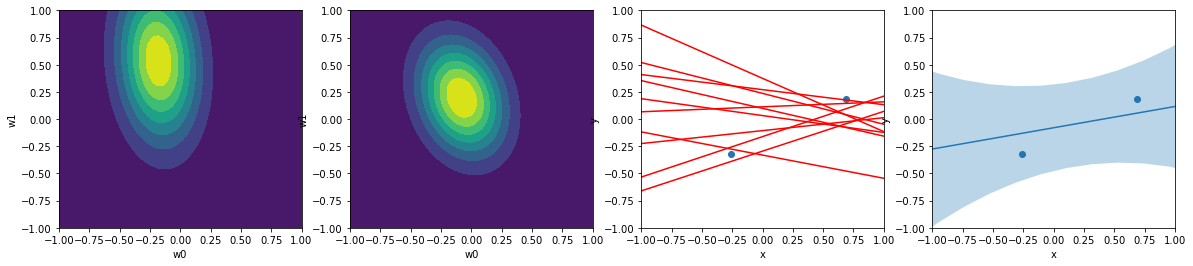

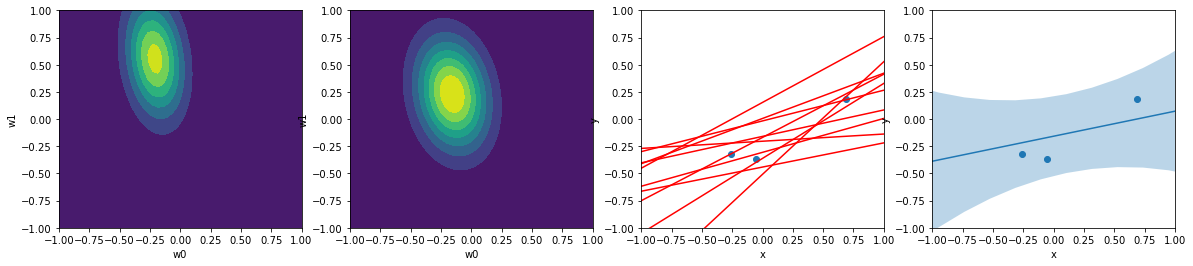

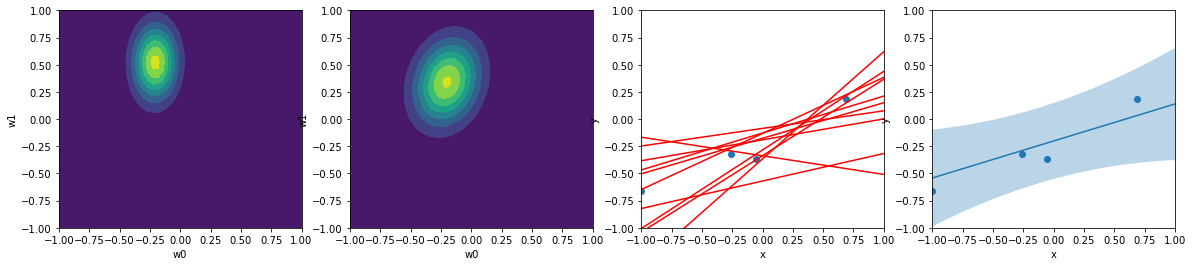

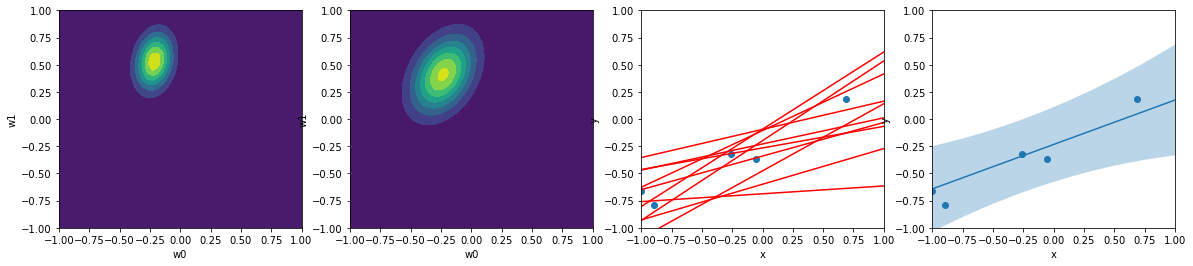

In [18]:
m = m_0
S = S_0

iters = 5
for i, ind in enumerate(np.random.permutation(len(X))[:iters]):
    x_sample = X[ind].reshape(1, -1)
    y_sample = y[ind].reshape(1, -1)

    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 4))
    #likelihood_plot(x_sample, y_sample, ax0)
    m, S = posterior(x_sample, y_sample, m, S)
    plot_over_w(m, S, ax1)
    if i == 0:
        all_x = x_sample
        all_y = y_sample
    else:
        all_x = np.concatenate((all_x, x_sample), axis=0)
        all_y = np.concatenate((all_y, y_sample), axis=0)
    total_likelihood_plot(all_x, all_y, ax0)
    plot_lines(m, S, ax2, all_x, all_y)
    plot_predictive_dist(m, S, ax3, all_x, all_y)

### Likelihood, posterior and samples from the posterior for all the dataset

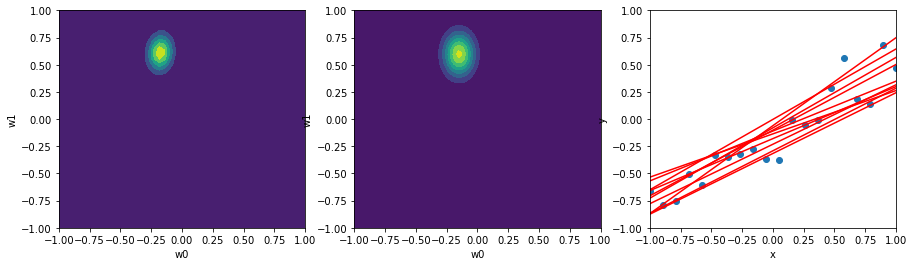

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
total_likelihood_plot(X, y, ax0)
m, S = posterior(X, y.reshape(-1, 1), m_0, S_0)
plot_over_w(m, S, ax1)
plot_lines(m, S, ax2, X, y.reshape(-1, 1))

### Predictive distribution on whole dataset

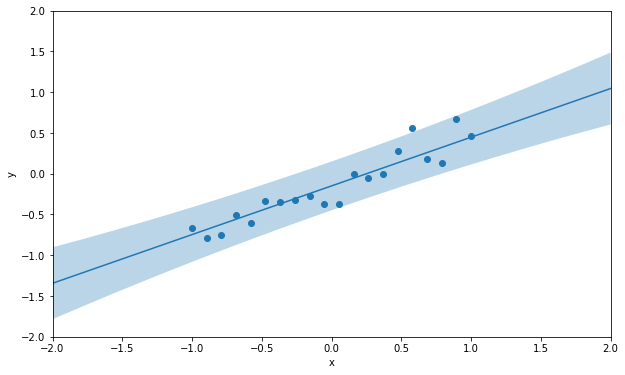

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_predictive_dist(m, S, ax, X, y, lim=2)